<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tqdm.autonotebook import tqdm
from IPython.display import clear_output
import seaborn as sns

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [5]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader_lfw = torch.utils.data.DataLoader(torch.from_numpy(train_photos).to(torch.float32), batch_size=32)
val_loader_lfw = torch.utils.data.DataLoader(torch.from_numpy(val_photos).to(torch.float32), batch_size=32)

In [6]:
images = next(iter(train_loader_lfw))
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

In [7]:
len(train_photos), len(val_photos)

(11828, 1315)

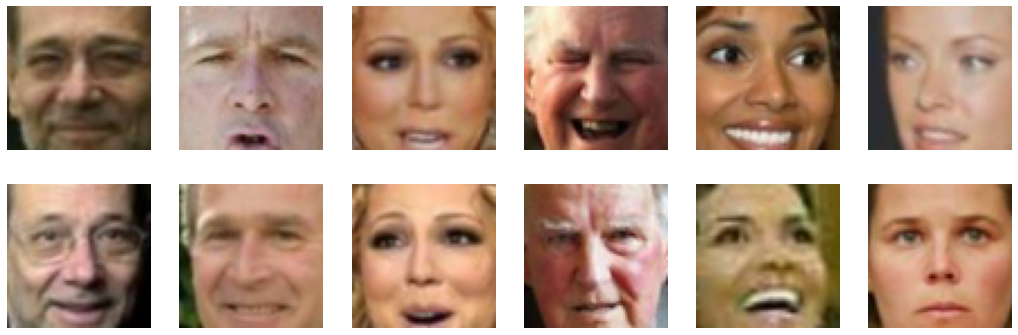

In [8]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = np.random.randint(len(train_photos) - 1)
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(train_photos[j+1])
plt.show();

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [9]:
dim_code = 128 # выберите размер латентного вектора
input_dim = 64 * 64 * 3

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [10]:
class AutoencoderConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),       
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        # 16 x 4 x 4
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3, 3), padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, sample):
        sample = sample.view(-1, 3, 64, 64)
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    def latent(self, sample):
        sample = sample.view(-1, 3, 64, 64) 
        latent = self.encoder(sample)
        return latent
    
    def sample(self, z):
        generated = self.decoder(z)
        return generated

In [11]:
criterion = nn.MSELoss()

model = AutoencoderConv().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

max_epoch = 100

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

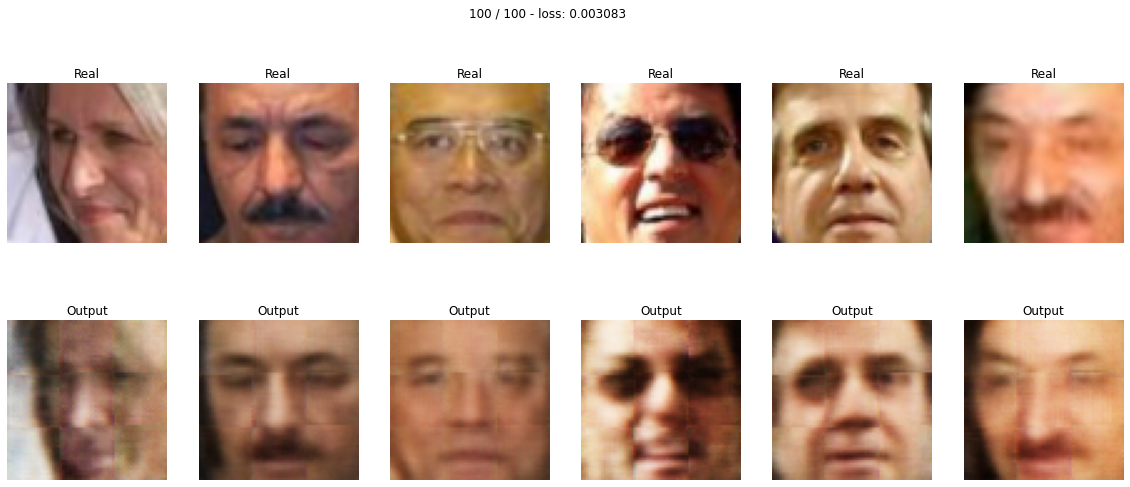

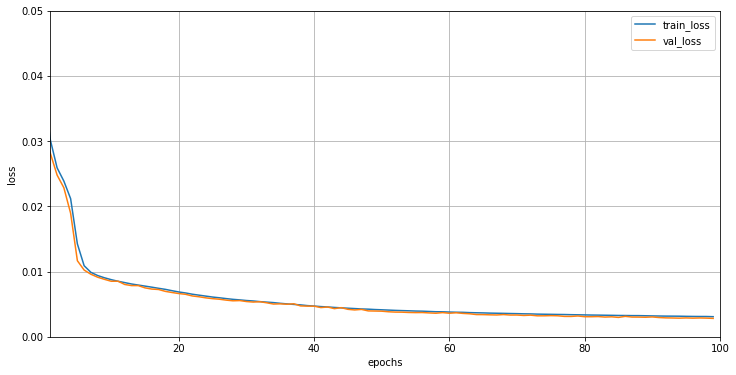

In [12]:
train_losses = []
val_losses = []

for epoch in tqdm(range(max_epoch)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader_lfw):
        optimizer.zero_grad()
        reconstructed, latent_code = model(X_batch.to(device))
        reconstructed = reconstructed.view(-1, 64, 64, 3)
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        X_val = next(iter(val_loader_lfw))
        Y_hat, _ = model(X_val.to(device))
        Y_hat = torch.clip(Y_hat.view(-1, 64, 64, 3).detach().cpu(), 0, 1)
        for X_batch in val_loader_lfw:
          reconstructed, latent_code = model(X_batch.to(device))
          reconstructed = reconstructed.view(-1, 64, 64, 3)
          loss = criterion(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    clear_output(wait=True)
    plt.figure(figsize=(20, 8))    
    for k in range(6):
        j = np.random.randint(len(X_val))
        plt.subplot(2, 6, k+1)
        plt.imshow(X_val[j])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[j])
        plt.title('Output')
        plt.axis('off')

    plt.suptitle('%d / %d - loss: %f' % (epoch+1, max_epoch, np.mean(train_losses_per_epoch)))
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.xlim(1, max_epoch)
    plt.ylim(0, 0.05)
    plt.ylabel("loss")
    plt.grid(visible=True)
    plt.show()

In [13]:
#torch.save(model.state_dict(), 'params.pkl')
#model.load_state_dict(torch.load('/content/params.pkl', map_location=torch.device(device)))

In [14]:
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [15]:
model.eval()
with torch.no_grad():
    for batch in val_loader_lfw:
      reconstruction, latent_code = model(batch.to(device))
      reconstruction = reconstruction.view(-1, 64, 64, 3)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

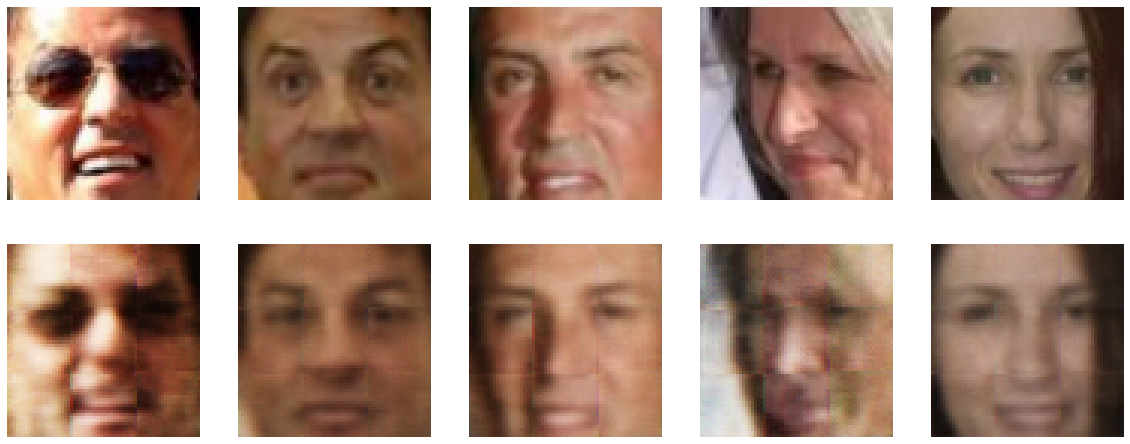

In [16]:
#sns.set(style="white", font_scale=1.4)

plt.figure(figsize=(20, 8))

for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(gt)
  plt.subplot(2, 5, i+6)
  plt.axis('off')
  plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [17]:
latents = torch.Tensor()
for inputs in tqdm(train_loader_lfw):
    inputs = inputs.to(device)
    with torch.no_grad():
        latent = model.latent(inputs).cpu()
        latents = torch.cat((latents, latent))
latents.shape

  0%|          | 0/370 [00:00<?, ?it/s]

torch.Size([11828, 256])

In [18]:
lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)
lat_mean.shape, lat_std.shape

(torch.Size([256]), torch.Size([256]))

In [19]:
def get_samples(model, batch):
    model.eval()
    with torch.no_grad():
        sample = model.sample(batch.to(device))
    sample = sample.view(-1, 3, 64, 64)
    sample = sample.cpu().detach()
    return sample

z = np.array([np.random.normal(0, 1, 256) for i in range(25)])
z = torch.FloatTensor(z)
z = z * lat_std/2 + lat_mean
samples = get_samples(model, z)


In [20]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array([np.random.normal(0, 3, 256) for i in range(25)])
output = model.sample(torch.FloatTensor(z).to(device))
output.shape

torch.Size([25, 3, 64, 64])

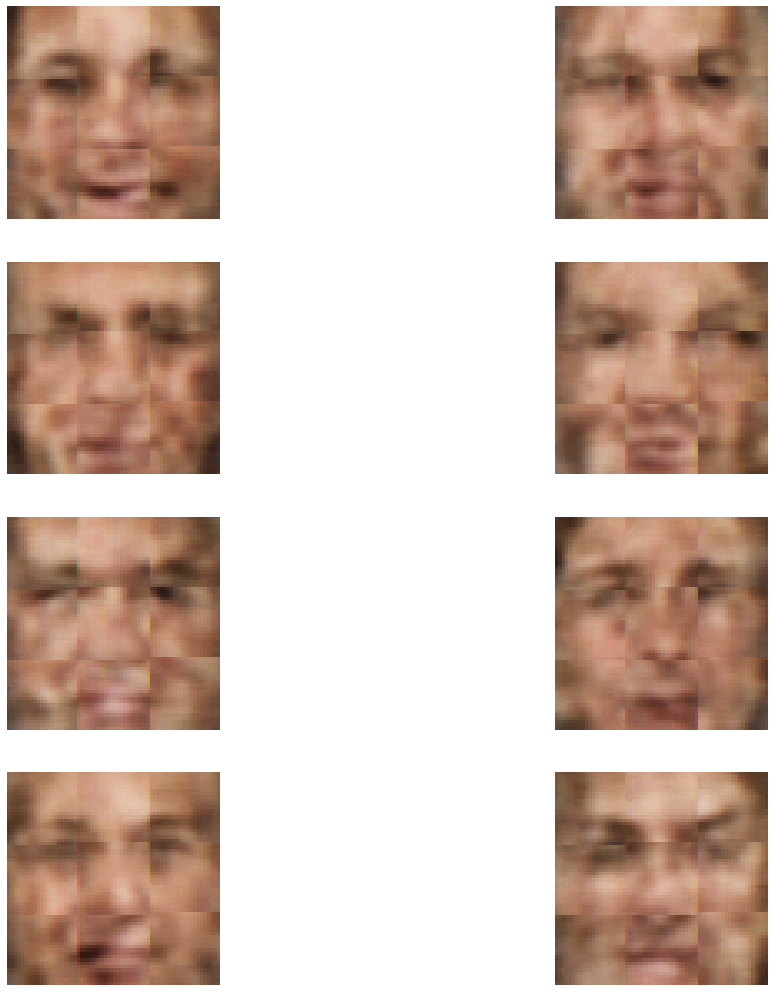

In [21]:
plt.figure(figsize=(18, 18))
for i in range(8):
  plt.subplot(4, 2, i + 1)
  generated = samples[i].view(64, 64, 3).cpu().detach().numpy()
  plt.imshow(generated)
  plt.axis('off')
plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

(0        -0.86499
 1        0.798544
 2        0.172817
 3        0.563327
 4        0.507786
            ...   
 11823    1.201503
 11824    0.347114
 11825   -1.135493
 11826    1.565299
 11827     1.14576
 Name: Smiling, Length: 11828, dtype: object,
 <matplotlib.image.AxesImage at 0x7effa88943d0>)

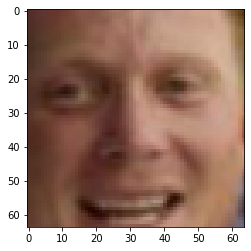

In [22]:
train_attrs['Smiling'], plt.imshow(train_photos[1])

In [23]:
smiles_idx = train_attrs['Smiling'].sort_values()[-20:].index
sad_idx = train_attrs['Smiling'].sort_values()[:20].index
smiles = torch.FloatTensor(train_photos[smiles_idx]).to(device)
sad = torch.FloatTensor(train_photos[sad_idx]).to(device)

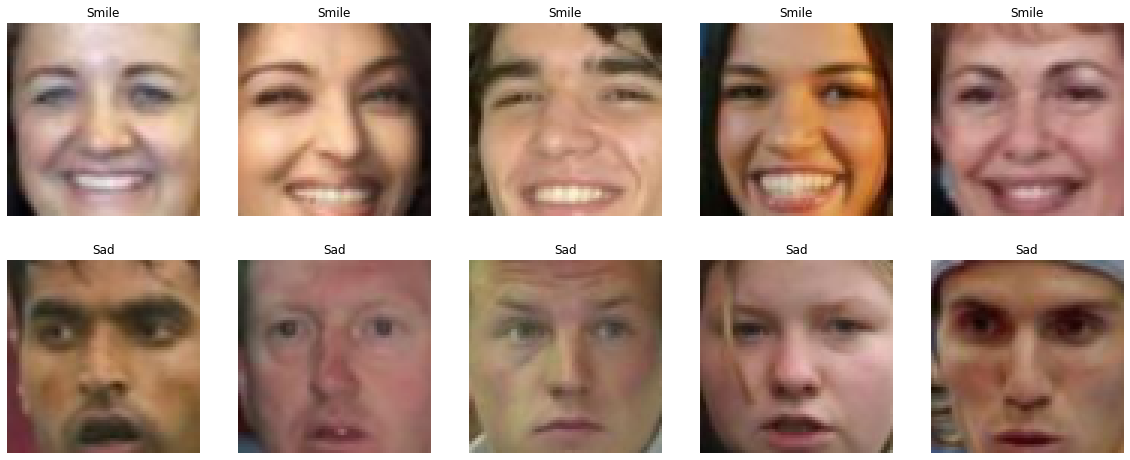

In [24]:
plt.figure(figsize=(20, 8))

for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.title('Smile')
  plt.axis('off')
  plt.imshow(smiles[i].cpu())
  plt.subplot(2, 5, i+6)
  plt.title('Sad')
  plt.axis('off')
  plt.imshow(sad[i].cpu())

In [25]:
model.eval()
with torch.no_grad():
    _, latent_sad = model(sad)
    latent_sad = latent_sad.cpu()
    _, latent_smile = model(smiles)
    latent_smile = latent_smile.cpu()
pure_smile = latent_smile.mean(dim=0) - latent_sad.mean(dim=0)

pure_smile.shape

torch.Size([256])

In [26]:
model.eval()
with torch.no_grad():
    _, latent_sad = model(sad)
    latent_sad = latent_sad.cpu()
    latent_sad_to_smile = (latent_sad + pure_smile).to(device)
    smile_faces = model.decoder(latent_sad_to_smile).view(-1, 64, 64, 3)
sad_faces, smile_faces = sad.cpu(), smile_faces.cpu()


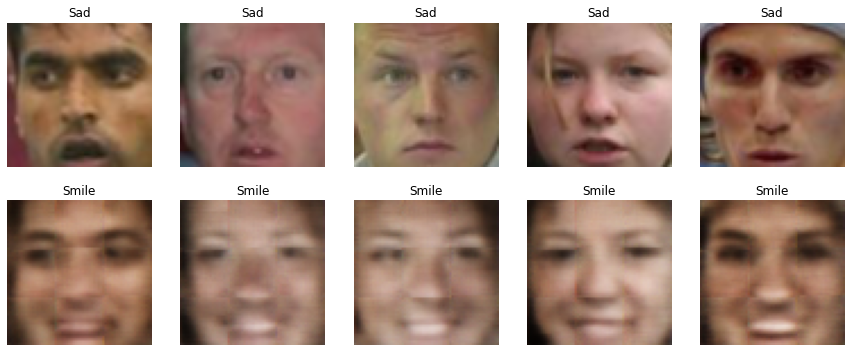

In [27]:
plt.figure(figsize=(15, 6))

for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.title('Sad')
  plt.axis('off')
  plt.imshow(sad_faces[i])
  plt.subplot(2, 5, i+6)
  plt.title('Smile')
  plt.axis('off')
  plt.imshow(smile_faces[i])

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [28]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader_mnist = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader_mnist = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [29]:
latent_size = 16

In [30]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size ** 2),
            nn.BatchNorm1d(latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, latent_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(latent_size * 2),
        )

        self.mu = nn.Linear(latent_size * 2, latent_size)
        self.logvar = nn.Linear(latent_size * 2, latent_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(latent_size * 2),
            nn.Linear(latent_size * 2, latent_size ** 2),
            nn.ReLU(),
            nn.BatchNorm1d(latent_size ** 2),
            nn.Linear(latent_size ** 2, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.logvar(x)
        logsigma = torch.exp(0.5 * log_var)
        return mu, logsigma
    
    def enocde_sample(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x)#.view(-1, 2, latent_size)
        return x
        
    def gaussian_sampler(self, mu, logsigma):
        if self.training: 
            eps = torch.randn_like(logsigma)
            sample = mu + (eps * logsigma)
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(z)
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [31]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)) /2/28/28

И обучим модель:

In [32]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

In [33]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for images, labels in train_loader_mnist:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(images.to(device))
        reconstruction = reconstruction.reshape(-1, 1, 28, 28)
        loss = criterion(images.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for images, labels in test_loader_mnist:
          reconstruction, mu, logsigma = autoencoder(images.to(device))
          reconstruction = reconstruction.reshape(-1, 1, 28, 28)
          loss = criterion(images.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/50 [00:00<?, ?it/s]

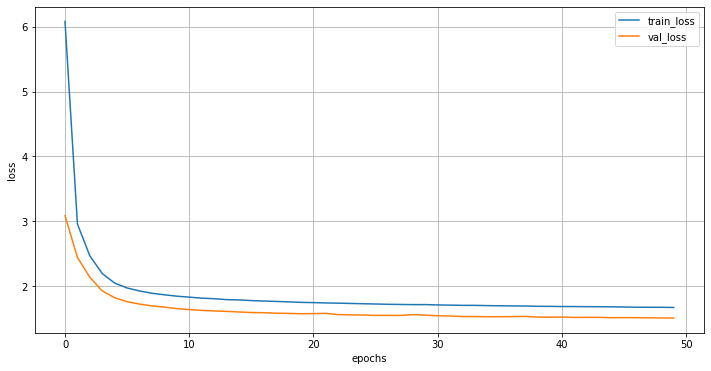

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(visible=True)
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [35]:
autoencoder.eval()
with torch.no_grad():
    for images, labels in test_loader_mnist:
        reconstruction, mu, logsigma = autoencoder(images.to(device))
        reconstruction = reconstruction.view(-1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = images.view(-1, 28, 28).numpy()
        break

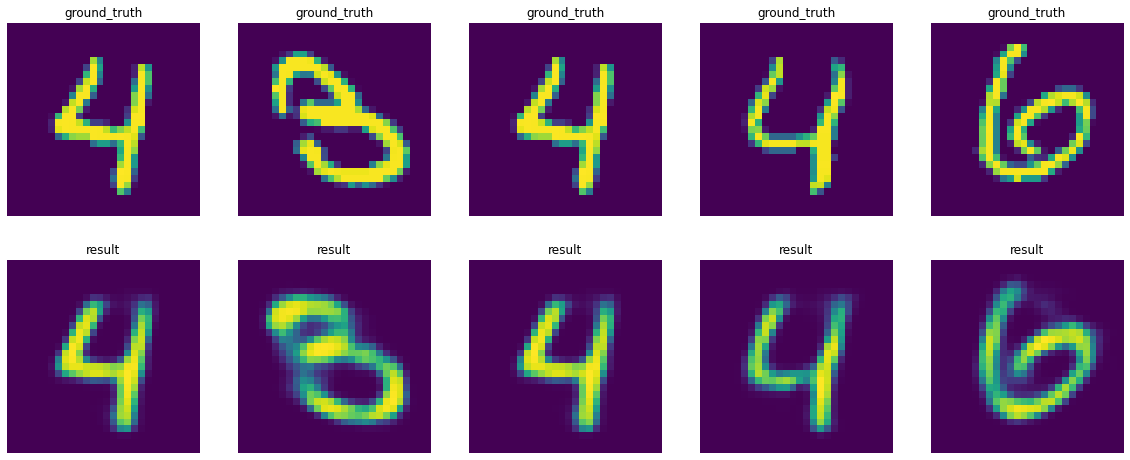

In [36]:
plt.figure(figsize=(20, 8))
for i in range(5):
  j = np.random.randint(len(result))
  plt.subplot(2, 5, i+1)
  plt.title('ground_truth')
  plt.axis('off')
  plt.imshow(ground_truth[j])
  plt.subplot(2, 5, i+6)
  plt.title('result')
  plt.axis('off')
  plt.imshow(result[j])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [37]:
def get_latent_representation(model, dataloader):
    latent_representation = []
    targets_list = []
    with torch.no_grad():
        for batch, target in dataloader:
            batch = batch.to(device)
            mu, logs = autoencoder.encode(batch)
            latent = autoencoder.gaussian_sampler(mu, logs)
            latent = latent.cpu().numpy()
            target = target.cpu().numpy()
            latent_representation.append(latent)
            targets_list.append(target)
        targets = np.concatenate(targets_list)
        latent_representation = np.concatenate(latent_representation)
        return latent_representation, targets

latent, targets = get_latent_representation(autoencoder, test_loader_mnist)
latent.shape, targets.shape

((10000, 16), (10000,))

In [38]:
lat_mean = latent.mean()
lat_std = latent.std()
lat_mean, lat_std

(0.00043012857, 0.14177473)

In [39]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(lat_mean, lat_std, 16) for i in range(40)])
z = torch.FloatTensor(z)
output = autoencoder.decoder(z.to(device))

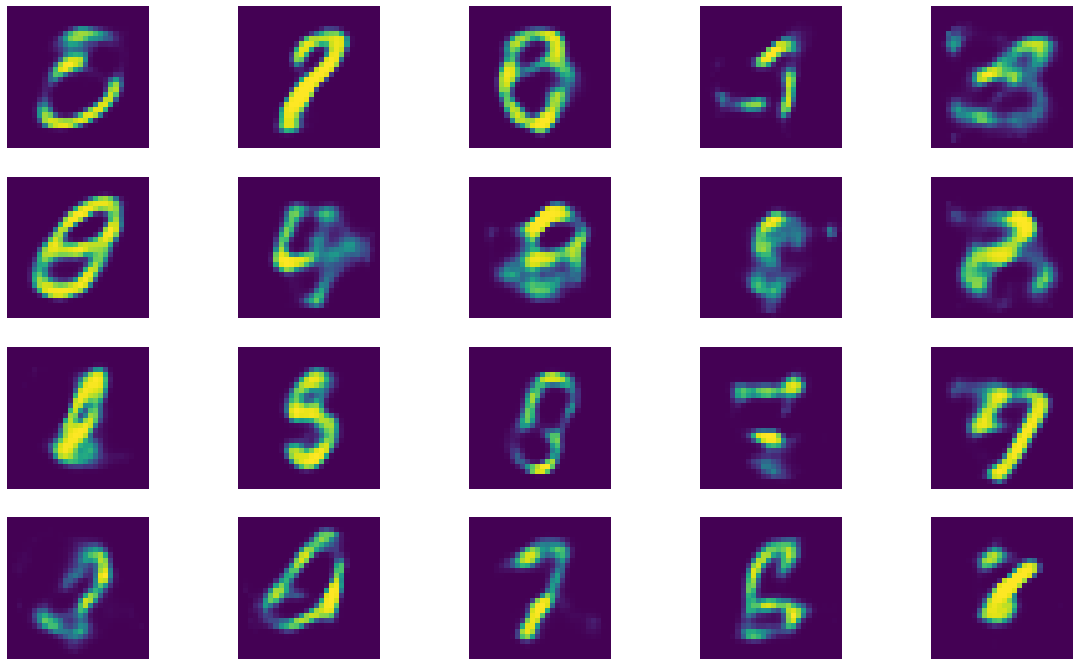

In [40]:
plt.figure(figsize=(20, 12))
for i in range(20):
  plt.subplot(4, 5, i + 1)
  generated = np.clip(output[i].view(28, 28).cpu().detach().numpy(), 0, 1)
  plt.axis('off')
  plt.imshow(generated)

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [41]:
tsne = TSNE(n_components=2, verbose=1, random_state=42)
z = tsne.fit_transform(latent)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 2.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.142620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.429054
[t-SNE] KL divergence after 1000 iterations: 1.782584


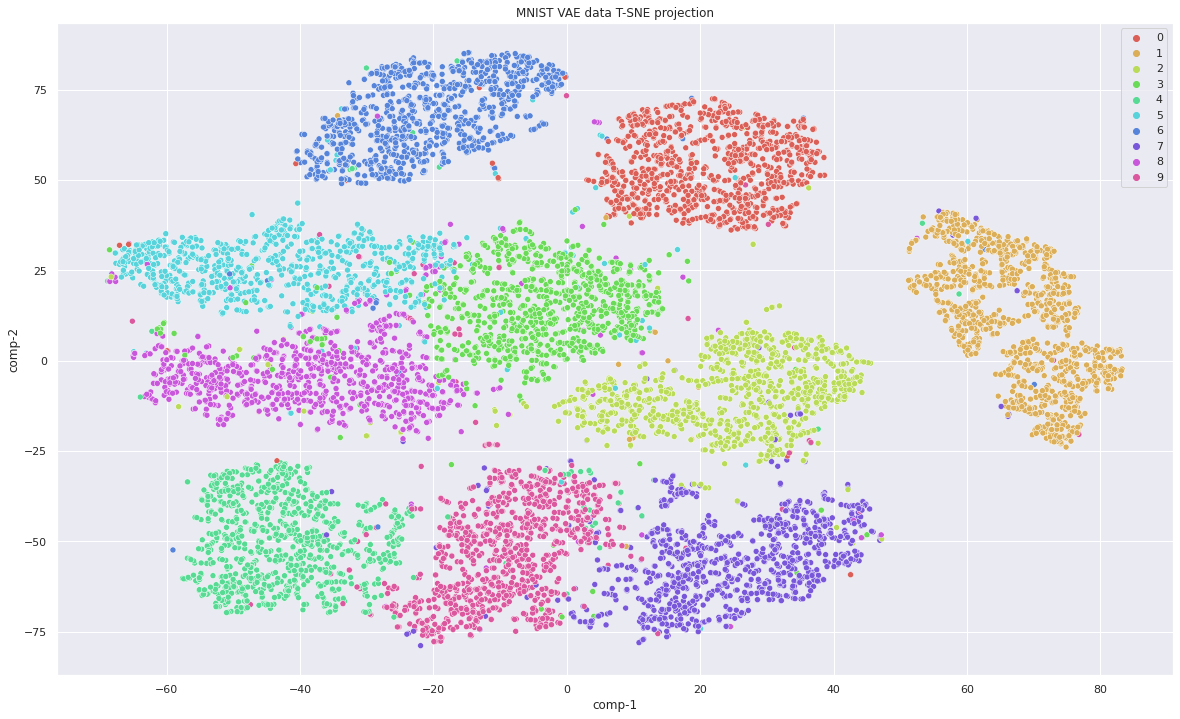

In [42]:
df = pd.DataFrame()
df["y"] = targets
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.set(rc={'figure.figsize':(20, 12)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST VAE data T-SNE projection");

Что вы думаете о виде латентного представления?

Мы видим что схожие классы образовали довольно плотные группы, но есть кластеры, которые близко расположены и имеют пересечения. Такие результаты могут указывать на схожесть написания разных цифр.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [43]:
HIDDEN_DIM = 16
NUM_CLASSES = 10

class CVAE3(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=(1 * 28 * 28 + NUM_CLASSES),
                out_features=256,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(HIDDEN_DIM * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=(HIDDEN_DIM + NUM_CLASSES),
                out_features=128,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(
                in_features=256,
                out_features=(1 * 28 * 28),
            ),
            nn.Sigmoid(),
        )
    
    def add_class_info(self, x, class_num):
        x = self.flatten(x)
        outx = torch.zeros(x.shape[0], x.shape[1] + NUM_CLASSES, dtype=torch.float32)
        outx[:, :(-NUM_CLASSES)] = x
        for i in range(x.shape[0]):
            outx[i, x.shape[1] + class_num[i]] = 1
        outx = outx.to(device)
        return outx
        
    def encode(self, x, class_num):
        x = self.add_class_info(x, class_num)
        x = self.encoder(x).view(-1, 2, HIDDEN_DIM)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu
    
    def decode(self, z, class_num):
        z = self.add_class_info(z, class_num)
        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, _ = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [44]:

criterion = loss_vae

autoencoder = CVAE3().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)



In [45]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for images, labels in train_loader_mnist:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(images.to(device), labels.to(device))
        reconstruction = reconstruction.reshape(-1, 1, 28, 28)
        loss = criterion(images.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for images, labels in test_loader_mnist:
          mu, logsigma, reconstruction = autoencoder(images.to(device), labels.to(device))
          reconstruction = reconstruction.reshape(-1, 1, 28, 28)
          loss = criterion(images.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/50 [00:00<?, ?it/s]

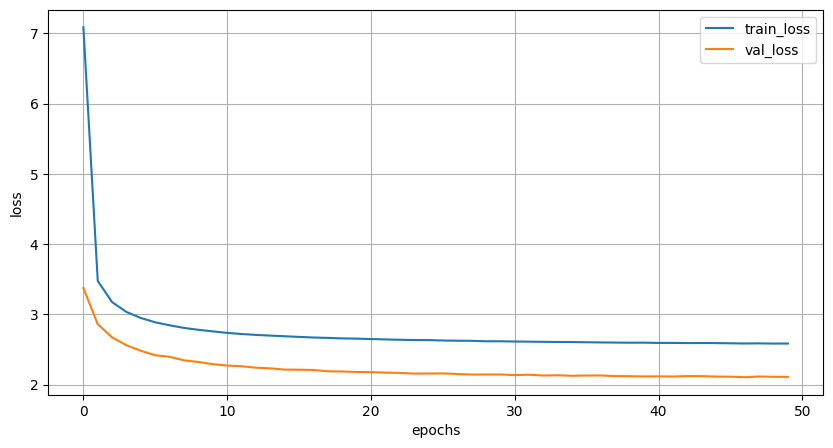

In [46]:
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(visible=True)
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [47]:
autoencoder.eval()
with torch.no_grad():
    for images, labels in test_loader_mnist:
        mu, logsigma, reconstruction = autoencoder(images.to(device), labels.to(device))
        reconstruction = reconstruction.view(-1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = images.view(-1, 28, 28).numpy()
        break

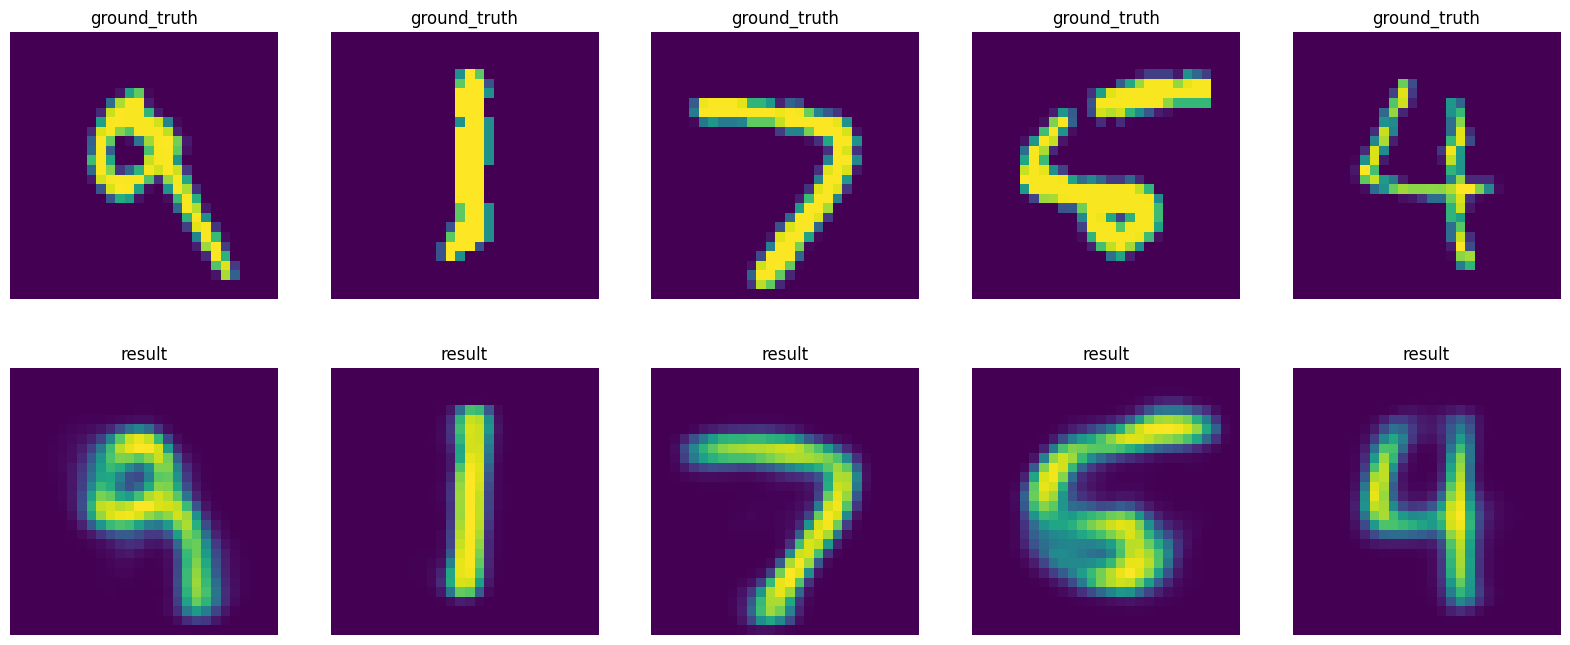

In [48]:
plt.figure(figsize=(20, 8))
for i in range(5):
  j = np.random.randint(len(result))
  plt.subplot(2, 5, i+1)
  plt.title('ground_truth')
  plt.axis('off')
  plt.imshow(ground_truth[j])
  plt.subplot(2, 5, i+6)
  plt.title('result')
  plt.axis('off')
  plt.imshow(result[j])

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])


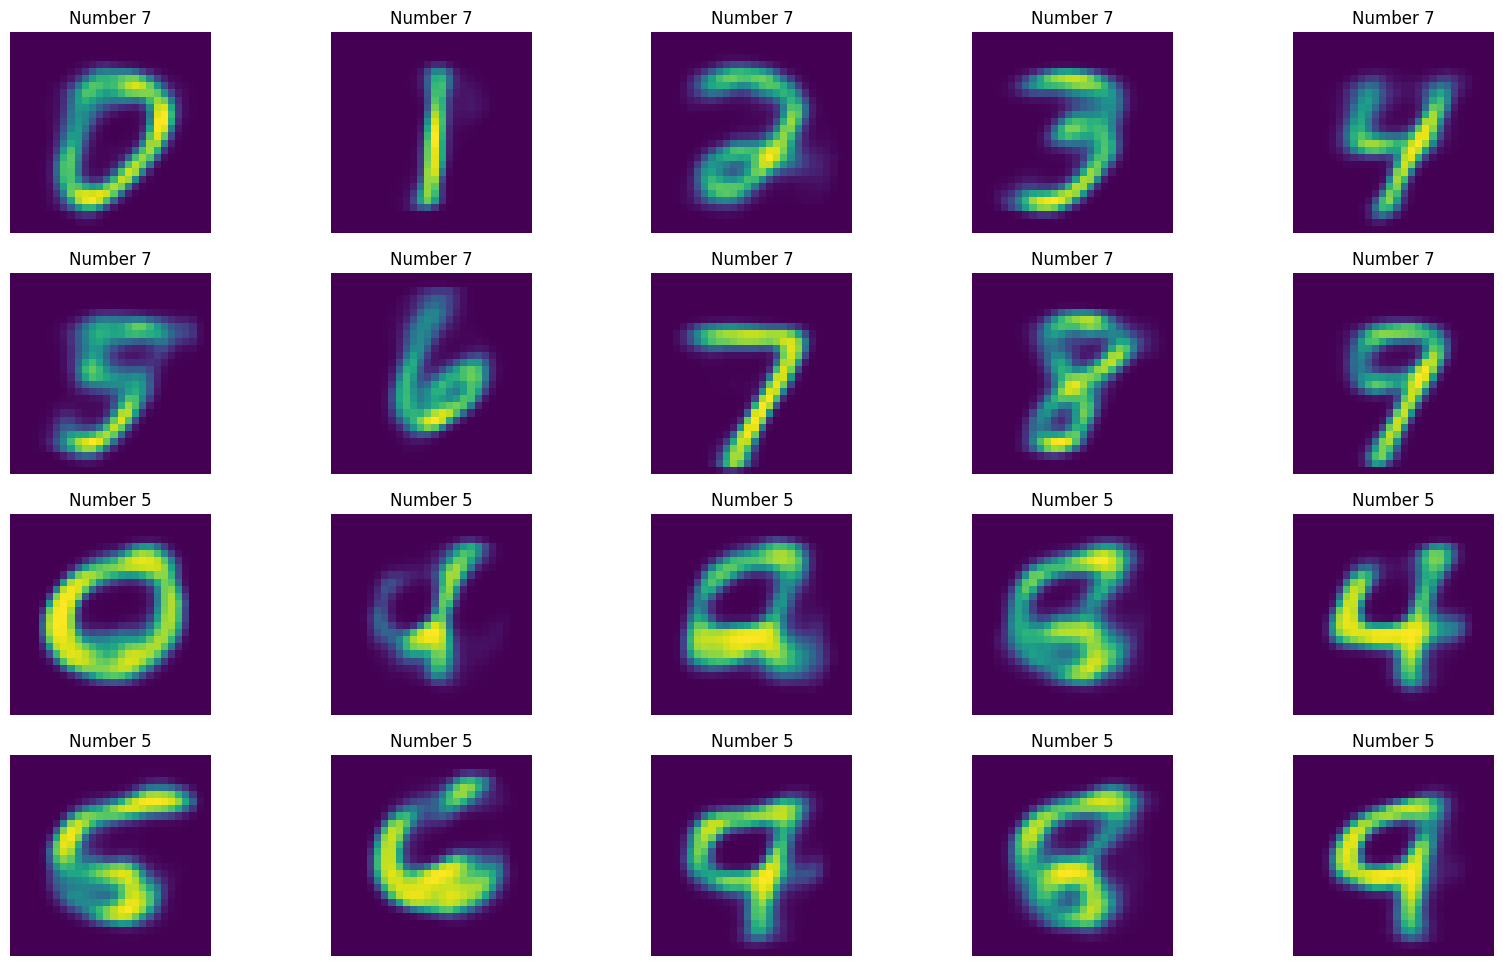

In [49]:
autoencoder.eval()
with torch.no_grad():
    test_imgs, test_labels = next(iter(test_loader_mnist))
    print(test_labels)
    mu, logsigma, _ = autoencoder.encode(
        test_imgs.to(device),
        test_labels.to(device),
    )
    z = autoencoder.gaussian_sampler(mu, logsigma)
    test_z7 = z[0][None,:]
    test_z5 = z[8][None,:]
    imgs7 = torch.Tensor()
    imgs5 = torch.Tensor()
    plt.figure(figsize=(20, 12))
    for i in range(NUM_CLASSES):
        test_class = torch.LongTensor([i])[None,:]
        reconstruction7 = autoencoder.decode(test_z7, test_class)
        reconstruction5 = autoencoder.decode(test_z5, test_class)
        imgs7 = torch.cat((imgs7, reconstruction7.cpu()))
        imgs5 = torch.cat((imgs5, reconstruction5.cpu()))
        plt.subplot(4, 5, i + 1)
        generated7 = imgs7[i]
        plt.title('Number 7')
        plt.axis('off')
        plt.imshow(generated7[0])
        
        plt.subplot(4, 5, i + 11)
        generated5 = imgs5[i]
        plt.title('Number 5')
        plt.axis('off')
        plt.imshow(generated5[0])

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [50]:
def get_latent_representation_CVAE3(model, dataloader):
    latent_representation = []
    targets_list = []
    with torch.no_grad():
        for batch, target in dataloader:
            batch = batch.to(device)
            mu, logs, class_num = autoencoder.encode(batch, target)
            latent = autoencoder.gaussian_sampler(mu, logs)
            latent = latent.cpu().numpy()
            target = target.cpu().numpy()
            latent_representation.append(latent)
            targets_list.append(target)
        targets = np.concatenate(targets_list)
        latent_representation = np.concatenate(latent_representation)
        return latent_representation, targets

In [51]:
latent, targets = get_latent_representation_CVAE3(autoencoder, test_loader_mnist)
latent.shape, targets.shape

((10000, 16), (10000,))

In [52]:
tsne = TSNE(n_components=2, verbose=0, random_state=42)
z = tsne.fit_transform(latent)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


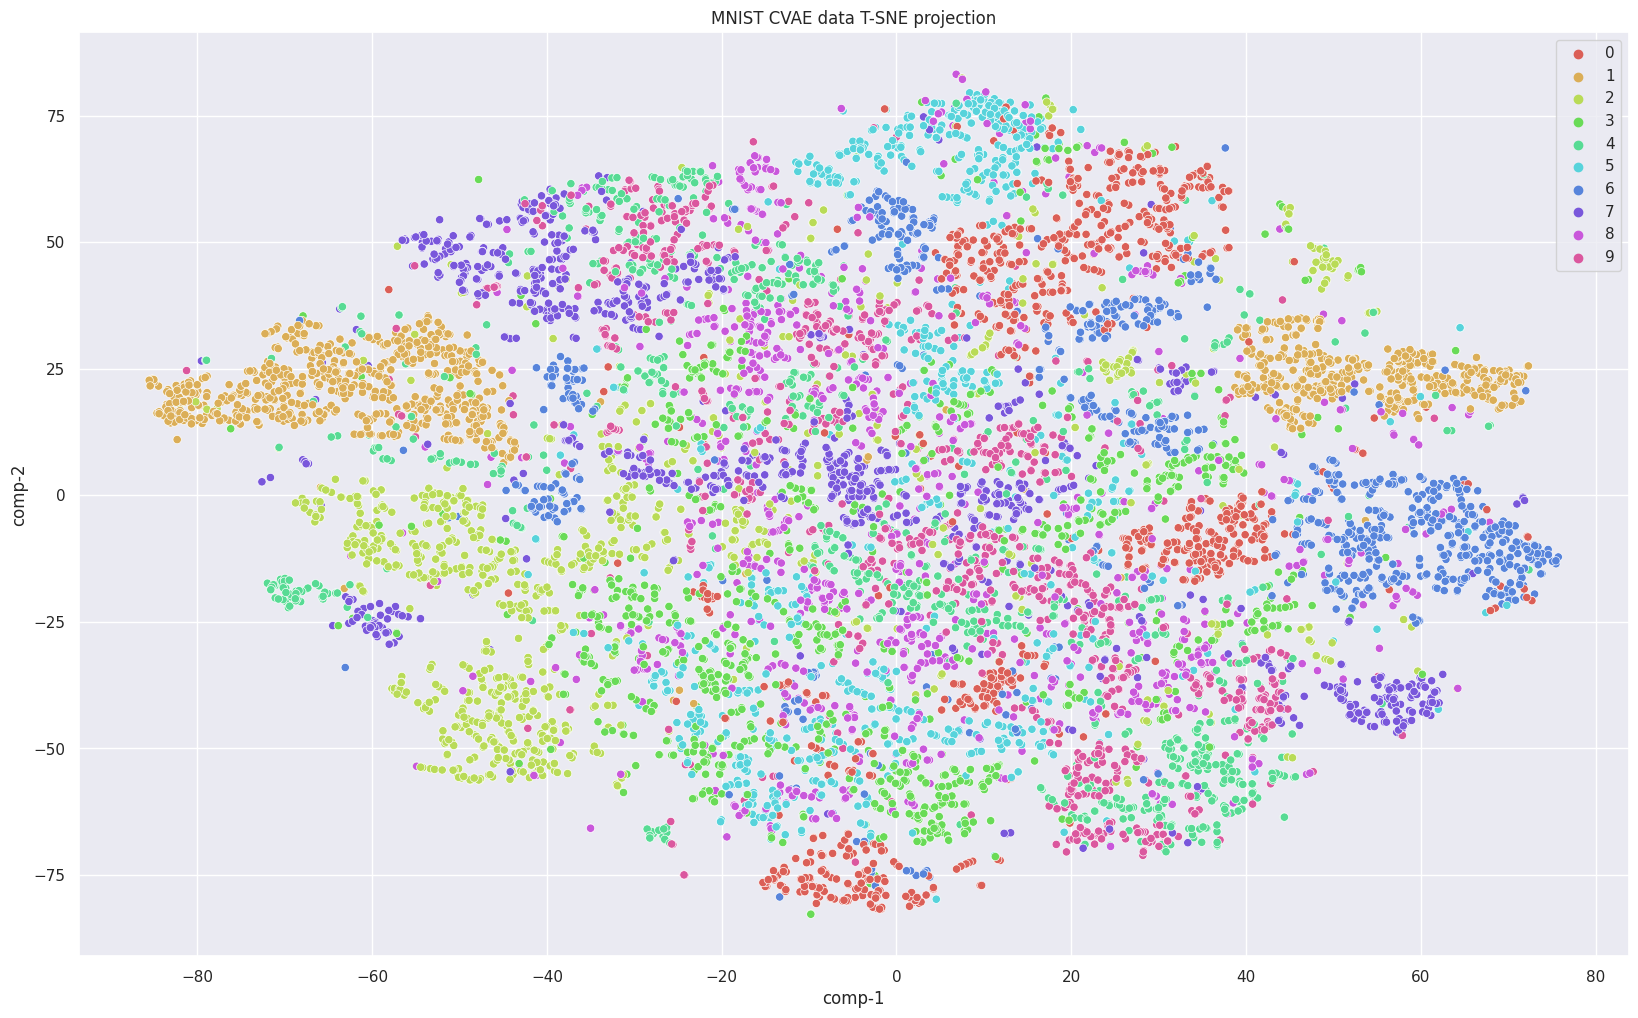

In [53]:
df = pd.DataFrame()
df["y"] = targets
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.set(rc={'figure.figsize':(20, 12)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST CVAE data T-SNE projection");

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Расположение классов отличается от VAE, здесь выделенны в кластеры не сами латентные представления цифр, а способ (стиль) их написания.